In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

root_dir = Path.cwd().parents[1]
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))

# from caiman.utils.utils import load_dict_from_hdf5
from matplotlib import pyplot as plt


## Prepare & display data

40


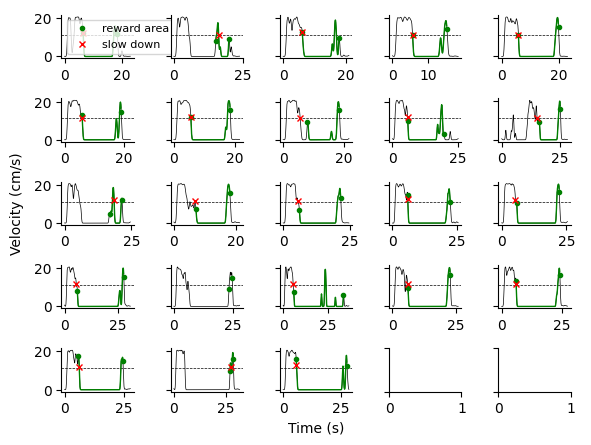

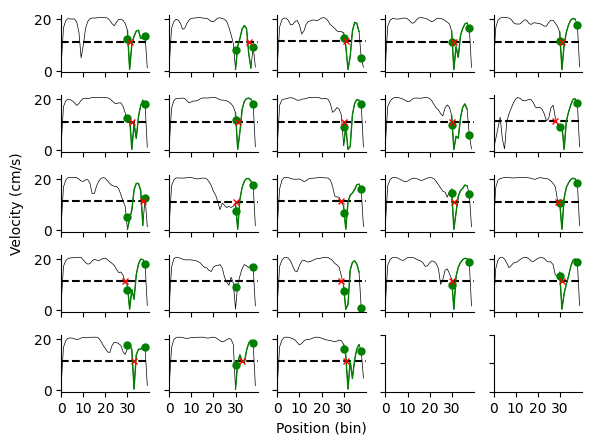

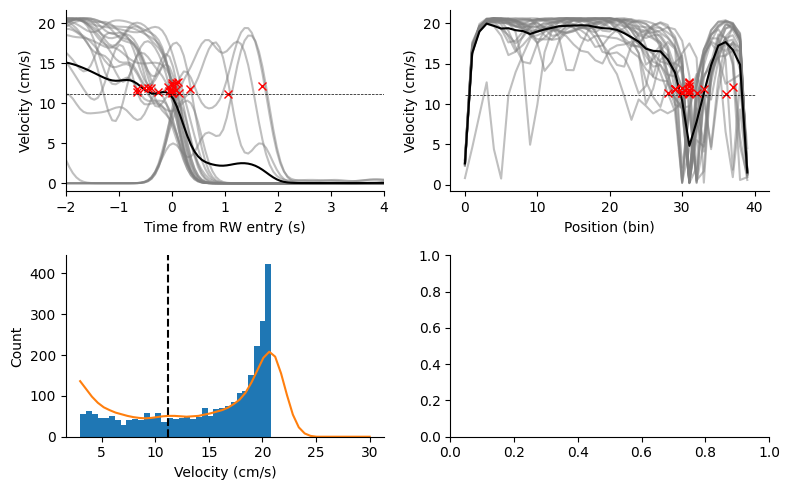

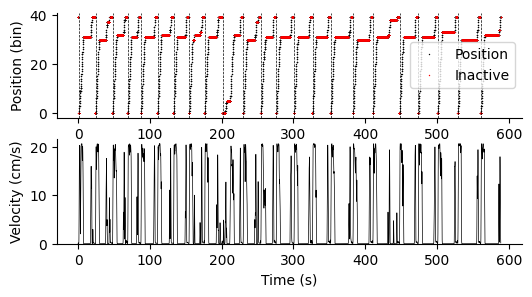

In [2]:
from placefield_detection.utils import prepare_behavior_from_file, plot_behavior

pathMouse = Path("../../../../data/845ad")
pathSession = pathMouse / "Session40"
f = 15.0
nbin = 40
only_active = True

pathBehavior = pathSession / "aligned_behavior.pkl"
behavior = prepare_behavior_from_file(
    pathBehavior,
    only_active=only_active,
    environment_length=120.0,
    nbin=nbin,
    f=15.0,
    T=None,
    calculate_performance=True,
    plt_bool=True,
    plt_trials=True,
)


plot_behavior(behavior)

In [3]:
import h5py
from typing import Dict
import scipy
import numpy as np


def load_dict_from_hdf5(filename: str) -> Dict:
    """Load dictionary from hdf5 file

    Args:
        filename: str
            input file to load
    Returns:
        dictionary
    """

    with h5py.File(filename, "r") as h5file:
        return recursively_load_dict_contents_from_group(h5file, "/")


def recursively_load_dict_contents_from_group(h5file: h5py.File, path: str) -> Dict:
    """load dictionary from hdf5 object
    Args:
        h5file: hdf5 object
            object where dictionary is stored
        path: str
            path within the hdf5 file

    Starting with Caiman 1.9.9 we started saving strings as attributes rather than independent datasets,
    which gets us a better syntax and less damage to the strings, at the cost of scanning properly for them
    being a little more involved. In future versions of Caiman we may store all scalars as attributes.

    There's some special casing here that should be solved in a more general way; anything serialised into
    hdf5 and then deserialised should probably go back through the class constructor, and revalidated
    so all the fields end up with appropriate data types.
    """

    ans: Dict = {}
    for akey, aitem in h5file[path].attrs.items():
        ans[akey] = aitem

    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            val_set = np.nan
            if isinstance(item[()], str):
                if item[()] == "NoneType":
                    ans[key] = None
                else:
                    ans[key] = item[()]

            elif key in [
                "dims",
                "medw",
                "sigma_smooth_snmf",
                "dxy",
                "max_shifts",
                "strides",
                "overlaps",
            ]:
                if isinstance(item[()], np.ndarray):
                    ans[key] = tuple(item[()])
                else:
                    ans[key] = item[()]
            else:
                if isinstance(item[()], np.bool_):  # sigh
                    ans[key] = bool(item[()])
                else:
                    ans[key] = item[()]
                    if isinstance(ans[key], bytes) and ans[key] == b"NoneType":
                        ans[key] = None

        elif isinstance(item, h5py._hl.group.Group):
            if key in ("A", "W", "Ab", "downscale_matrix", "upscale_matrix"):
                data = item[path + key + "/data"]
                indices = item[path + key + "/indices"]
                indptr = item[path + key + "/indptr"]
                shape = item[path + key + "/shape"]
                ans[key] = scipy.sparse.csc_matrix(
                    (data[:], indices[:], indptr[:]), shape[:]
                )
                if key in ("W", "upscale_matrix"):
                    ans[key] = ans[key].tocsr()
            else:
                ans[key] = recursively_load_dict_contents_from_group(
                    h5file, path + key + "/"
                )
    return ans

In [ ]:
from placefield_detection.utils import prepare_activity, plot_activity

pathActivity = [
    file
    for file in pathSession.iterdir()
    if (
        file.stem.startswith("results_CaImAn")
        and not "compare" in file.stem
        and "redetected" in file.stem
    )
][0]

ld = load_dict_from_hdf5(pathActivity)

# neuron_activity = prepare_activity(
#     ld["S"][0, :],
#     behavior,
#     f=f,
#     only_active=only_active,
# )

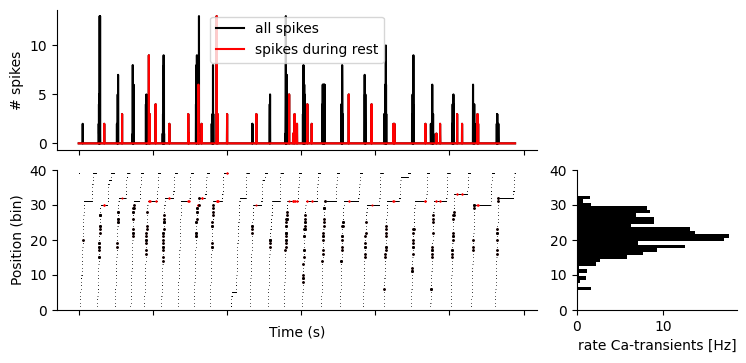

In [41]:
n = 11
neuron_activity = ld["S"].copy()
activity = prepare_activity(neuron_activity[n, :], behavior, f=15.0, only_active=True)

# from placefield_detection.alternative_detection_methods import (
#     peak_method_batch,
#     information_method_batch,
#     stability_method

plot_activity(activity, behavior, f=f)

## Test Bayes Hierarchical Method

In [42]:
import numpy as np
from placefield_detection.BayesModel import HierarchicalBayesInference
from placefield_detection.HierarchicalBayesModel import (
    parse_name_and_indices,
)
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    run_sampling,
)

HBI = HierarchicalBayesInference(logLevel="ERROR")
HBI.prepare_data(
    activity["map_trial_spikes"],
    behavior["trials"]["dwelltime"],
    iter_dims=False,
    dimension_names=["trials", "position_bins"],
)

n_field = 1
HBI.set_priors(N_f=n_field)

In [43]:
from placefield_detection.HierarchicalBayesModel.structures import (
    build_distr_structure_from_params,
)
from placefield_detection.BayesModel import place_field

p = np.random.rand(HBI.n_params)
my_prior_transform = HBI.set_prior_transform(vectorized=False)
p_transformed = my_prior_transform(p)

params = HBI.get_params_from_p(p_transformed)
build_distr_structure_from_params(params, "field", place_field)

{'fields': [place_field(A=array([[1.06229382]]), sigma=array([[0.51190893]]), theta=array([[19.588544  , 16.29314134, 19.9353829 , 17.01808766, 22.42782862,
          18.70074868, 21.7836384 , 16.67715753, 19.09499398, 18.36414754,
          17.15350727, 18.49548676, 19.85679471, 23.26344169, 25.4010438 ,
          18.05852354, 21.41018058, 21.79849321, 17.50137255, 16.61719007,
          21.04327541, 14.38085226, 15.36099832]]))],
 'A0': array([[0.19672573]])}

In [44]:
my_likelihood = HBI.set_logp_func(vectorized=False)
my_likelihood(p_transformed)

-2989.025521577727

In [ ]:
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    run_sampling,
)

results, sampler = run_sampling(
    my_prior_transform,
    my_likelihood,
    HBI.parameter_names_all,
    nP=6,
    n_live=200,  # , periodic=[3]
)

running nested sampling


7561it [01:58, 63.55it/s, +200 | bound: 104 | nc: 1 | ncall: 1370502 | eff(%):  0.566 | loglstar:   -inf < -2152.682 <    inf | logz: -2190.857 +/-  0.404 | dlogz:  0.005 >  1.000]


In [ ]:
"""
* reenable wrapping of theta
* change dwelltime_trials to be in toplevel
* change bayesModel to not contain storing functions, but move these to separate utils
"""

'1.15.2'

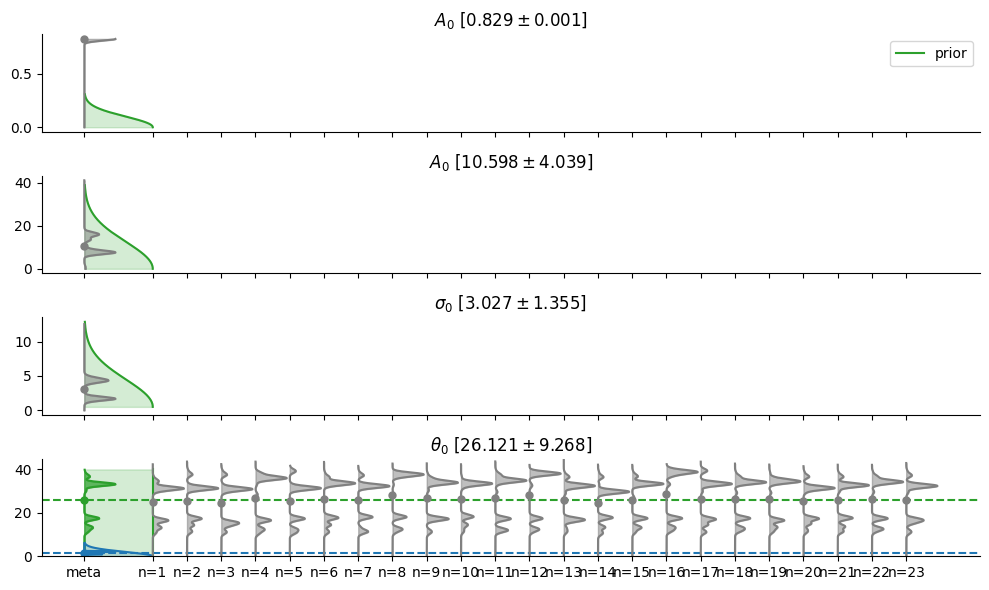

In [48]:
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    plot_results,
)
from placefield_detection.analyze_results import display_results

plot_results(HBI, results, mode="dynesty")
# display_results(results)

In [ ]:
from HierarchicalBayesModel.NestedSamplingMethods import get_mean_from_sampler

mean_params = get_mean_from_sampler(results, HBI.parameter_names_all, mode="dynesty")
mean_params

{'A0': 0.8291736533232711,
 'A_field0': 10.59804999553515,
 'sigma_field0': 3.026758787781412,
 'theta_field0_mean': 26.1213997089274,
 'theta_field0_sigma': 1.5778543102098077,
 'theta_field0_0': 24.804602987870172,
 'theta_field0_1': 25.44045145930446,
 'theta_field0_2': 24.76058359084747,
 'theta_field0_3': 27.0400962461488,
 'theta_field0_4': 25.314132666685193,
 'theta_field0_5': 26.50371849326636,
 'theta_field0_6': 25.770046834790584,
 'theta_field0_7': 28.11010696316117,
 'theta_field0_8': 26.649532661751305,
 'theta_field0_9': 26.331447098261968,
 'theta_field0_10': 26.721536644796778,
 'theta_field0_11': 28.32436134232497,
 'theta_field0_12': 25.920829531838145,
 'theta_field0_13': 24.540243412599263,
 'theta_field0_14': 26.11428913845765,
 'theta_field0_15': 28.794928605451823,
 'theta_field0_16': 26.355344884803127,
 'theta_field0_17': 26.436442107169842,
 'theta_field0_18': 26.352513256669056,
 'theta_field0_19': 25.432696483264507,
 'theta_field0_20': 25.906777830241207,


## Test other methods

p_value p_value


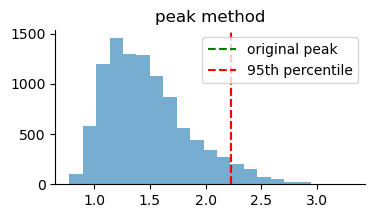

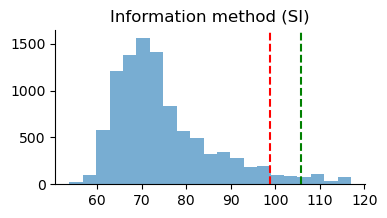

In [6]:
from placefield_detection.alternative_detection_methods import (
    peak_method,
    information_method,
)

neuron = 11
neuron_activity = ld["S"][:, behavior["active"]]
shuffles = 10000
is_pc, p_val = peak_method(
    behavior, neuron_activity[neuron, :], shuffles, False, plot=True
)
is_pc, p_val_info = information_method(
    behavior, neuron_activity[neuron, :], shuffles, False, plot=True
)
print(p_val, p_val_info)

In [7]:
from placefield_detection.alternative_detection_methods import (
    peak_method_batch,
    information_method_batch,
    # stability_method,
)

print(neuron_activity.shape)
# information_method(
#     behavior,
#     neuron_activity[0, :],
#     n_shuffles=10000,
#     plot=True,
# )

# results_info = information_method_batch(
#     behavior,
#     neuron_activity,
#     n_shuffles=10000,
# )
is_place_cell, p_value = peak_method_batch(
    behavior,
    neuron_activity,
    n_shuffles=10000,
)
# stability_method(
#     behavior,
#     neuron_activity,
#     neurons,
#     nbin,
# )

(848, 2855)


100%|██████████| 848/848 [00:51<00:00, 16.53it/s]


TypeError: list indices must be integers or slices, not str

In [ ]:
from placefield_detection.utils import (
    get_firingmap,
    obtain_significant_events_from_one_sided_process,
)

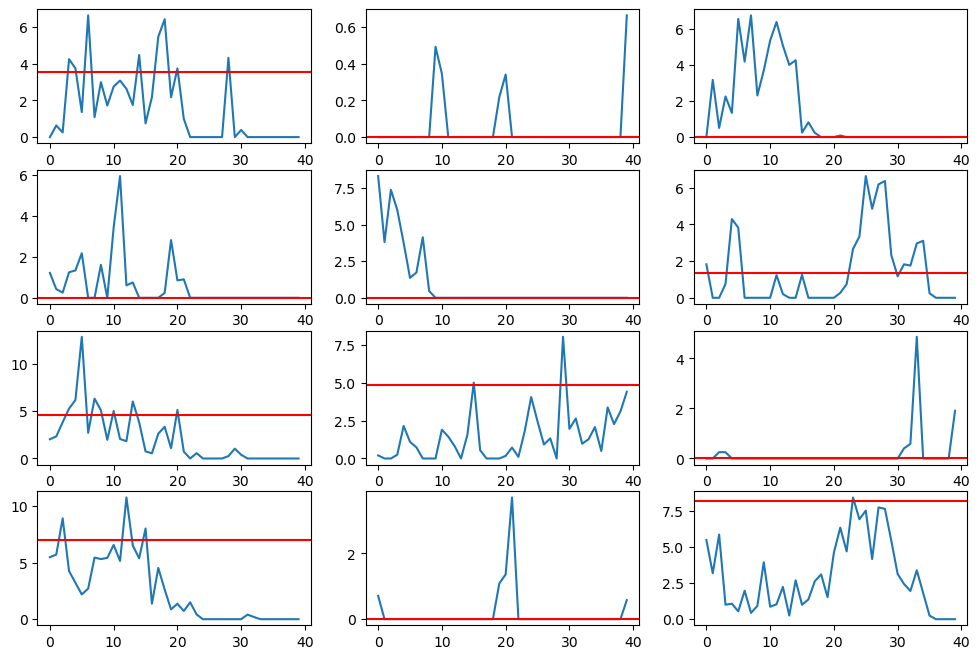

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(12, 8))

for neuron in range(12):

    activity = prepare_activity(
        neuron_activity[neuron, :], behavior, f=f, only_active=only_active
    )

    fmap = get_firingmap(
        activity["spikes"],
        behavior["position"],
        behavior["dwelltime"],
        nbin=behavior["nbin"],
    )
    # frate, threshold, _ = get_firingrate(neuron_activity[0,:],IQR=True)
    field, threshold, sd_r = obtain_significant_events_from_one_sided_process(
        fmap, baseline_mode="percentile", sd_mode="iqr", prctile=50
    )
    # print("sd_r:", sd_r)
    # baseline_prc, sd = estimate_stats_from_one_sided_process(fmap, "percentile", "iqr")
    # print("\n")
    # frate, threshold, PF = get_firingrate(fmap, sd_r=-1, IQR=False)
    # frate, threshold_IQR, PF = get_firingrate(fmap, sd_r=-1, IQR=True)

    ax = axes[neuron // 3, neuron % 3]
    ax.plot(fmap, label="firing map")
    ax.axhline(threshold, color="r", linestyle="-", label="threshold")
    # ax.axhline(baseline_prc, color="g", linestyle="-", label="baseline %")
    # ax.axhline(threshold + 2 * sd, color="r", linestyle="--", label="threshold SD")
    # ax.axhline(
    # baseline_prc + 2 * sd_iqr, color="g", linestyle="--", label="threshold SD"
    # )
    # ax.set_title(f"Neuron {neuron}")
    # print(threshold, "vs", threshold_IQR)
    # print(PF)

[[0.         0.         0.         ... 0.         0.04293704 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02147177 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[       nan        nan        nan ...        nan 0.04293704        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan 0.02147177        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


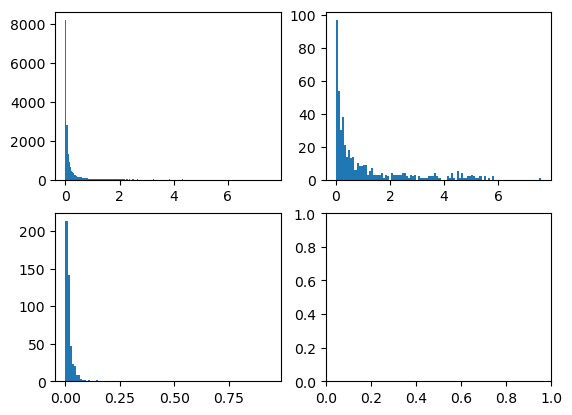

In [49]:
# activity =
import numpy as np

act_masked = np.ma.masked_array(neuron_activity, mask=neuron_activity == 0)
act_masked = np.ma.filled(act_masked, np.nan)
print(neuron_activity)
print(act_masked)
fig, axes = plt.subplots(2, 2)
axes[0][0].hist(neuron_activity[neuron_activity > 0], bins=200)
axes[0][1].hist(np.nanmax(act_masked, axis=1), bins=100)
axes[1][0].hist(np.nanpercentile(act_masked, 20, axis=1), bins=100)
plt.show()

# test namras method

In [9]:
from placefield_detection.alternative_detection_methods.thresholding_pf_method import (
    thresholding_method_single,
    thresholding_method_batch,
)


# print(neuron_activity.shape)
# results = thresholding_method_single(behavior, ld["S"][3, :], plot=True)
results = thresholding_method_single(behavior, neuron_activity[11, :], plot=True)
results
# place_fields = thresholding_method_batch(behavior, neuron_activity, sigma=2)

NameError: name 'neuron_activity' is not defined

In [ ]:
behavior["dwelltime"].shape

(40,)

{}


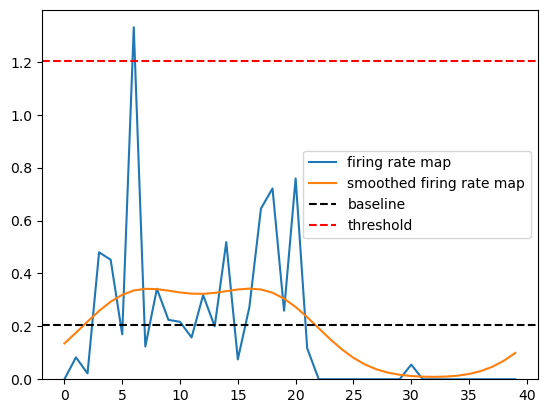

In [118]:
for neuron in range(1):
    field = thresholding_method_single(
        behavior, neuron_activity[neuron, :], threshold_factor=4, sigma=4, plot=True
    )
    print(field)
# field = thresholding_method_single(
#     behavior, neuron_activity[4, :], sigma=2, plot=True
# )
# field